In [1]:
import numpy as np
from qiskit import *
from qiskit.compiler import transpile
from multiprocessing import Pool
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.extensions import *
from qiskit.extensions.unitary import UnitaryGate
from scipy.linalg import schur

In [62]:
def rand_cx(n):
    q1 = np.random.randint(n)
    q2 = np.delete(np.arange(n), q1)
    q2 = np.random.choice(q2, size=1)[0]
    return 'cx q[' + str(q1) + '],q[' + str(q2) + '];\n', q1, q2

def supremacy_circuit(bend=None, m=1, n=3):
    sqrtx = 'u3(1.57079632679490,-1.57079632679490,1.57079632679490)'
    sqrty = 'u3(1.57079632679490,0,0)'
    sqrtw = 'u3(1.57079632679490,-0.785398163397448,0.785398163397449)'
    gates = [sqrtx, sqrty, sqrtw]
    
    qasm_base = """OPENQASM 2.0;
                include "qelib1.inc";
                qreg q[n];"""
    
    last_gates = -np.ones(n, dtype=np.int64)
    s = qasm_base.replace('[n]', '[' + str(n) + ']')
    for i in range(m):
        # single-qubit gates
        for j in range(n):
            choices = np.arange(len(gates))
            if last_gates[j] != -1:
                choices = np.delete(choices, last_gates[j])
            g = np.random.choice(choices, size=1)[0]
            last_gates[j] = g
            s += gates[g] + ' q[' + str(j) + '];\n'
        
        # two-qubit gate
        # g, q1, q2 = rand_cx(n)
        # s += g
        # last_gates[q1] = -1
        # last_gates[q2]
    first_half = QuantumCircuit.from_qasm_str(s)
    qc = transpile(first_half, backend=bend, optimization_level=0)
    s = qc.qasm()
    # for i in range(n):
    #     s += 'measure q[' + str(i) + '] -> c[' + str(i) + '];\n'
    return s

In [63]:
n = 3
m = 2
s = supremacy_circuit(m=m, n=n)
qc = QuantumCircuit.from_qasm_str(s)
qc.draw()

┌─────────────────────┐┌─────────────────────┐
q_0: ┤ U3(pi/2,-pi/2,pi/2) ├┤ U3(pi/2,-pi/4,pi/4) ├
     └───┬──────────────┬──┘├─────────────────────┤
q_1: ────┤ U3(pi/2,0,0) ├───┤ U3(pi/2,-pi/4,pi/4) ├
     ┌───┴──────────────┴──┐└───┬──────────────┬──┘
q_2: ┤ U3(pi/2,-pi/4,pi/4) ├────┤ U3(pi/2,0,0) ├───
     └─────────────────────┘    └──────────────┘

In [56]:
# measuring fidelity

# from qiskit.quantum_info import state_fidelity

# # set up qc1 and qc2

# backend = Aer.get_backend('state_vector')

# sv1 = execute(qc1, backend).result().get_statevector(qc1)
# sv2 = execute(qc2, backend).result().get_statevector(qc2)

# print(state_fidelity(sv1, sv2))

https://www.youtube.com/watch?v=kWHSH2HgbNQ continuous action space, actor/critic

http://proceedings.mlr.press/v32/silver14.pdf deterministic policy gradient algorithms

One 'game' can be the computer building a circuit and choosing parameters for a given depth D

Reward at end of game can be fidelity i.e. < 0.5 few points, 0.5 < |<\psi|\phi>|^2 < 0.75 more points, > 0.9 most points, for example

Restrict the network to only build the circuit forwards. Either give it a fixed amount of gates sqrtx/y/z cnot or choose to do nothing. This would make the state space significantly smaller I think. Or have it choose a ry/z/x cnot gate as well as a theta. But still make it only build up, which decreases number of actions it could make.

so really the actions are:
    gate on qb 1...n with a theta.
    cnot gate between two qbs
I guess there are a lot of options still

at least if there is no theta to pick the action space will be discrete. The state space will still be continuous though, maybe a circuit and a fidelity

In [57]:
# shape: (# channels, # layers, # qubits)
# only put u3 and cx channels; u1 and u2 are encoded in u3 channel since they are rare
def circuit_to_image(s3: str, n=5, n_channels=4, max_size=16):
    # create array to determine where gaps are, assuming latest-as-possible scheduling
    s3 = s3.replace('pi', 'np.pi')
    trimmed = s3[s3.find('qreg'):s3.find('barrier')].splitlines()[1:]
    trimmed.reverse()
    print(trimmed)
    circuit_arr = np.zeros((n, max_size), dtype=np.int64)
    circuit_img = np.zeros((n, max_size, n_channels))
    
    for ind in range(len(trimmed)):
        line = trimmed[ind]
        offset = 0
        qubits = []
        for i in range(2):
            q1_start = line.find('q', offset)
            if q1_start == -1:
                break
            q1_end = line.find(']', q1_start)
            qubit = line[q1_start+2:q1_end]
            qubits.append(int(qubit))
            offset = q1_end
        col_num = []
        for q in qubits:
            if len(np.nonzero(circuit_arr[q])[0]) != 0:
                col_num.append(np.max(np.nonzero(circuit_arr[q])))
        if len(col_num) == 0:
            col_num = 0
        else:
            col_num = np.max(col_num) + 1
        if col_num >= max_size:
            break
        for i in range(len(qubits)):
            q = qubits[i]
            circuit_arr[q][col_num] = 1 + ind
            if 'u1' in line:
                args = line[line.find('(') + 1 : line.find(')')].split(',')
                circuit_img[q][col_num][0] = eval(args[0])
                circuit_img[q][col_num][1] = -1
                circuit_img[q][col_num][2] = -1
            elif 'u2' in line:
                args = line[line.find('(') + 1 : line.find(')')].split(',')
                circuit_img[q][col_num][0] = eval(args[0])
                circuit_img[q][col_num][1] = eval(args[1])
                circuit_img[q][col_num][2] = -1
            elif 'u3' in line:
                args = line[line.find('(') + 1 : line.find(')')].split(',')
                circuit_img[q][col_num][0] = eval(args[0])
                circuit_img[q][col_num][1] = eval(args[1])
                circuit_img[q][col_num][2] = eval(args[2])
            elif 'cx' in line:
                circuit_img[q][col_num][3] = i*2 - 1
    
    image = np.swapaxes(circuit_img, 0, 2)
    return image

In [58]:
arr = circuit_to_image(s, n=n, max_size=m*2)
# arr = circuit_to_image('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncreg c[3];\nu3(pi/2,-pi/4,pi/4) q[0];\nu3(pi/2,-pi/4,pi/4) q[1];\ncx q[0],q[1];', n=3, max_size=4)

[&#39;u3(np.pi/2,-np.pi/4,np.pi/4) q[2];&#39;, &#39;cx q[1],q[0];&#39;, &#39;u3(np.pi/2,-np.pi/4,np.pi/4) q[1];&#39;, &#39;cx q[2],q[1];&#39;, &#39;u3(np.pi/2,0,0) q[2];&#39;, &#39;u3(np.pi/2,0,0) q[1];&#39;, &#39;u3(np.pi/2,-np.pi/4,np.pi/4) q[0];&#39;, &#39;u3(np.pi/2,0,0) q[0];&#39;]


&lt;matplotlib.image.AxesImage at 0x15a40b22b70&gt;

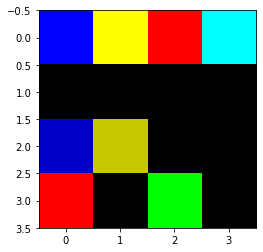

In [59]:
import matplotlib.pyplot as plt
plt.imshow(arr)

In [1]:
def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

valid_imshow_data(arr)

NameError: name 'arr' is not defined

In [21]:
def random_unitary(dim: int) -> np.ndarray:
  # follows the algorithm in https://arxiv.org/pdf/math-ph/0609050.pdf
  # returns a unitary of size dim x dim
  Z = np.array([np.random.normal(0, 1) + np.random.normal(0, 1) * 1j for _ in range(dim ** 2)]).reshape(dim, dim)
  Q, R = np.linalg.qr(Z)
  diag = np.diagonal(R)
  lamb = np.diag(diag) / np.absolute(diag)
  unitary = np.matmul(Q, lamb)

  # this condition asserts that the matrix is unitary
  assert np.allclose(unitary.conj().T @ unitary, np.eye(dim))

  return unitary

def random_density():
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(-np.pi, np.pi)
    state = np.cos(theta / 2) * np.array([1,0]) + np.exp(1j * phi) * np.sin(theta / 2) * np.array([0, 1])
    return state

In [39]:
rmax = -1
rmin = 1
imax = -1
imin = 1
for i in range(100000):
    s = random_density()
    u = np.outer(s, s)
    if (np.amax(u.real) > rmax):
        rmax = np.amax(u.real)
    if (np.amin(u.real) < rmin):
        rmin = np.amin(u.real)    
    if (np.amax(u.imag) > imax):
        imax = np.amax(u.imag)
    if (np.amin(u.imag) < imin):
        imin = np.amin(u.imag)
print(rmax, rmin, imax, imin) 

0.9999999985924828 -0.9999352271597755 0.999903027012202 -0.9999867516921784


In [37]:
np.outer(s, s)

array([[ 0.90135752+0.j        , -0.27301306-0.11989999j],
       [-0.27301306-0.11989999j,  0.06674391+0.07263325j]])

In [38]:
s

array([ 0.94939851+0.j        , -0.28756424-0.12629048j])

In [6]:
H = np.array([[1,1],[1,-1]]) * 1/np.sqrt(2)
I = np.array([[1,0],[0,1]])
CNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [9]:
CNOT @ np.kron(H, I)

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.        ,  0.70710678],
       [ 0.        ,  0.70710678,  0.        , -0.70710678],
       [ 0.70710678,  0.        , -0.70710678,  0.        ]])